<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part5/P5_Ch06_CH06_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM seq2seq

## DataLoader 만들기

In [1]:
!pip install portalocker

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
from datetime import datetime

drive_project_root = '/content/drive/MyDrive/#fastcampus'
sys.path.append(drive_project_root)
!pip install -r '/content/drive/MyDrive/#fastcampus/requirements.txt'

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >=0 :
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell')
else :
    print(gpu_info)

Fri Jul 14 13:05:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install omegaconf
!pip install torch_optimizer
!pip install wandb
!pip install efficientnet_pytorch==0.7.1
!pip install hydra-core==1.1
!pip install pytorch-lightning
!pip install --upgrade torchmetrics
!pip install --upgrade pytorch-lightning

In [5]:
# for data loading
from typing import List
from typing import Dict
from typing import Union
from typing import Any
from typing import Optional
from typing import Iterable
from typing import Callable
from abc import abstractmethod
from abc import ABC
from datetime import datetime
from functools import partial
from collections import Counter
from collections import OrderedDict
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
import pytorch_lightning as pl
from pprint import pprint

from torchtext import data
from torchtext import datasets
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import Vocab, build_vocab_from_iterator, vocab
import spacy

# for contiguration
from omegaconf import DictConfig
from omegaconf import OmegaConf
import hydra
from hydra.core.config_store import ConfigStore

# for logger
from torch.utils.tensorboard import SummaryWriter
import wandb
os.environ["WANDB_START_METHOD"] ="thread"

In [6]:

%cd /content/drive/MyDrive/#fastcampus
from data_utils import dataset_split
from config_utils import flatten_dict
from config_utils import register_config
from config_utils import configure_optimizers_from_cfg
from config_utils import get_loggers
from config_utils import get_callbacks
%cd /content


/content/drive/MyDrive/#fastcampus
/content


In [7]:
# download spacy data
!python -m spacy download en
!python -m spacy download en_core_web_sm
!python -m spacy download de
!python -m spacy download de_core_news_sm


2023-07-14 13:06:40.487013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-07-14 13:07:00.261139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-07-14 13:07:12.616259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
     ━━━━━━━━━━

In [8]:
data_spacy_de_en_cfg = {
    "name" : "spacy_de_en",
    "data_root" : os.path.join(os.getcwd(), "data"),
    "tokenizer" : "spacy",
    "src_lang" : "de",
    "tgt_lang" : "en",
    "src_index" : 0,
    "tgt_index" : 1,
    "vocab" :{
        "special_symbol2index" :{
            "<unk>" : 0, # 모르는 단어 처리
            "<pad>" : 1, # 길이 다른것 패딩으로 처리
            "<bos>" : 2, # 끝부분 표시
            "<eos>" : 3, # 첫부분 표시
        } ,
        "special_first" : True, # 위의 것들을 맨처음으로 배치
        "min_freq" : 2,
    }
}

data_cfg = OmegaConf.create(data_spacy_de_en_cfg)
print(OmegaConf.to_yaml(data_cfg))

name: spacy_de_en
data_root: /content/data
tokenizer: spacy
src_lang: de
tgt_lang: en
src_index: 0
tgt_index: 1
vocab:
  special_symbol2index:
    <unk>: 0
    <pad>: 1
    <bos>: 2
    <eos>: 3
  special_first: true
  min_freq: 2



In [9]:
train_data, valid_data, test_data = Multi30k(data_cfg.data_root)
test_data = to_map_style_dataset(test_data)

In [10]:
for i in test_data :
    print(i)
    break

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.', 'A man in an orange hat starring at something.')


In [11]:
# 1. token_transform ( token ... )
def get_token_transform(data_cfg : DictConfig) -> dict :
    token_transform : dict ={}
    token_transform[data_cfg.src_lang] = get_tokenizer(
        data_cfg.tokenizer, language = data_cfg.src_lang
        )
    token_transform[data_cfg.tgt_lang] = get_tokenizer(
        data_cfg.tokenizer, language = data_cfg.tgt_lang
        )
    return token_transform

token_transform = get_token_transform(data_cfg)

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [12]:
# 2. vocab_transform

def yeild_tokens(
    data_iter : Iterable, lang : str, lang2index : Dict[str, int],
) -> List[str] :
    """help function to yeild list of tokens"""
    for data_sample in data_iter:
        yield token_transform[lang](data_sample[lang2index[lang]])

def get_vocab_transform(data_cfg : DictConfig) -> dict :
    vocab_transform : dict = {}
    for ln in [data_cfg.src_lang, data_cfg.tgt_lang]:
        # build from train_data
        train_iter = Multi30k(
            split = 'train', language_pair =(data_cfg.src_lang, data_cfg.tgt_lang)
        )
        # create torchtext's Vocab object
        vocab_transform[ln] =build_vocab_from_iterator(
            yeild_tokens(
                train_iter,
                ln,
                {
                    data_cfg.src_lang : data_cfg.src_index,
                    data_cfg.tgt_lang : data_cfg.tgt_index,
                }
            ),
            min_freq = data_cfg.vocab.min_freq,
            specials = list(data_cfg.vocab.special_symbol2index.keys()),
            special_first = True
        )

    # set UNKNOWM as the default index, --> index가 unknown으로 return : token이 찾아지지 않을 경우
    # 만약 세팅되지 않으면 runtime error가 날 수 있다.
    for ln in [data_cfg.src_lang, data_cfg.tgt_lang]:
        vocab_transform[ln].set_default_index(
            data_cfg.vocab.special_symbol2index["<unk>"]
            )
    return vocab_transform

vocab_transform = get_vocab_transform(data_cfg)


In [13]:
print(vocab_transform['de']['<bos>'])
print(vocab_transform['en']['<bos>'])
print(vocab_transform['en']['hello'],vocab_transform['en']['world'])

2
2
5465 1870


In [14]:
# 3. integrated transforms
# --> text_transform : [token_transform -> vocab_transform -> torch.tensor transform]

# helper function for collate_fn

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms :
            txt_input = transform(txt_input)
        return txt_input
    return func

# convert to torch.tensor with bos & eos
def tensor_transform(token_ids : List[int], bos_index : int, eos_index : int ):
    return torch.cat(
        (   torch.tensor([bos_index]),
            torch.tensor(token_ids) ,
            torch.tensor([eos_index])
            )
        )

# src & tgt lang language text_transforms to convert raw strings --> tensor indices
def get_text_transform(data_cfg):
    text_transform = {}
    for ln in [data_cfg.src_lang, data_cfg.tgt_lang]:
        text_transform[ln] = sequential_transforms(
            token_transform[ln],
            vocab_transform[ln],
            partial(
                tensor_transform,
                bos_index = data_cfg.vocab.special_symbol2index["<bos>"],
                eos_index = data_cfg.vocab.special_symbol2index["<eos>"],
            )
        )
    return text_transform

text_transform = get_text_transform(data_cfg)

In [15]:
print(text_transform["en"]('hello'))
print(text_transform["en"]('hello,'))
print(text_transform["en"]('hello, how'))
print(text_transform["en"]('hello, how are you ?'))

tensor([   2, 5465,    3])
tensor([   2, 5465,   15,    3])
tensor([   2, 5465,   15,  889,    3])
tensor([   2, 5465,   15,  889,   17, 1328, 2470,    3])


In [16]:
# 4. collate_fn --> batch를 전처리 할까?

def collate_fn(batch, data_cfg: DictConfig):
    src_batch , tgt_batch =[], []

    for src_sample, tgt_sample in batch :
        src_batch.append(text_transform[data_cfg.src_lang](src_sample.rstrip('\n')))
        tgt_batch.append(text_transform[data_cfg.tgt_lang](tgt_sample.rstrip('\n')))

    src_batch = pad_sequence(src_batch, padding_value= data_cfg.vocab.special_symbol2index['<pad>'])
    tgt_batch = pad_sequence(tgt_batch, padding_value= data_cfg.vocab.special_symbol2index['<pad>'])
    return src_batch, tgt_batch

def get_collate_fn(cfg : DictConfig):
    return partial(collate_fn, data_cfg = cfg.data)

# 5. DataLoader

def get_multi30k_dataloader(split_mode : str , language_pair : tuple, batch_size : int, collate_fn: Callable):

    iter = Multi30k(split=split_mode, language_pair =language_pair)
    dataset = to_map_style_dataset(iter)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size =batch_size ,
        collate_fn = collate_fn )
    return dataloader

In [19]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


## pytorch - lighting

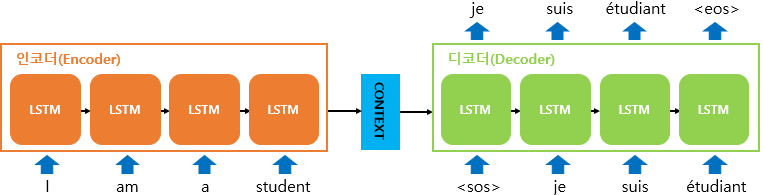


In [29]:
def _test_postprocessing(res : List[str]) -> str :
  if '<eos>' in res :
    res = res[:res.index('<eos>')]
  if '<pad>' in res:
    res = res[:res.index['<pad>']]
  res = " ".join(res).replace("<bos>", "")
  return res


class BaseTranslateLightningModule(pl.LightningModule):
  def __init__(self, cfg : DictConfig):
    super().__init__()
    self.cfg = cfg
    self.loss_function = torch.nn.CrossEntropyLoss(
        ignore_index = cfg.data.vocab.special_symbol2index['<pad>'] # 학습 안하기 위해 지정
    )
  def configure_optimizers(self):
    self._optimizers, self._schedulers = configure_optimizers_from_cfg(
        self.cfg, self
    )
    return self._optimizers, self._schedulers

  @abstractmethod # 모델마다 forward가 다르기 때문에 지정. 추상화 메소드
  def forward(self, src, tgt, teacher_forcing_ratio = float):
    raise NotImplementedError()

  def _forward(self, src, tgt, mode : str, teacher_forcing_ratio: float = 0.5):
    # teacher forcing :
    # seq2seq 에서 많이 쓰인다.
    # src -> tgt autoregressive 학습하면, 맨 최초는 학습을 빠르게 한다. 근데 미래부분학습은 ? -> 앞부분 될때까지 기다리기 너무 힘들다
    # 랜덤으로 미래정보도 조금 둬서 뒤에 있는 정보도 학습이 가능하게 하자
    # 0.5 ? --> 0.5확률로 teacher_forcing을 하겠다.

    assert mode in ['train', 'val', 'test']

    # get predictions
    # teacher forcing 용 input -->
    tgt_inputs = tgt[:-1, :] # delete ends for teacher forcing inputs : 맨 뒷부분이 필요하지 않아서 제거한다
    outputs = self(src, tgt_inputs, teacher_forcing_ratio = teacher_forcing_ratio)
    tgt_outputs = tgt[1:, :] # delete start token

    loss = self.loss_function(
        outputs.reshape(-1, outputs.shape[-1]), # [ batch x sequence, other_output_shape]
        tgt_outputs.reshape(-1),
        )
    logs_detail ={
        f"{mode}_src" : src ,
        f"{mode}_tgt" : tgt ,
        f"{mode}_results" : outputs ,

    }

    if mode in ["val", "test"]:
      _, tgt_results = torch.max(outputs, dim = 2)

      src_texts =[]
      tgt_texts =[]
      res_texts =[]

      # convert [L X B X others] --> [B X L X others]
      for src_i in torch.transpose(src, 0, 1).detach().cpu().numpy().tolist(): # no gradient, use cpu, numpy transform, list
        res = vocab_transform[self.cfg.data.src_lang].lookup_tokens(src_i)
        src_texts.append(_test_postprocessing(res))

      for tgt_i in torch.transpose(tgt, 0, 1).detach().cpu().numpy().tolist(): # no gradient, use cpu, numpy transform, list
        res = vocab_transform[self.cfg.data.tgt_lang].lookup_tokens(tgt_i)
        tgt_texts.append(_test_postprocessing(res))

      for tgt_res_i in torch.transpose(tgt_results, 0, 1).detach().cpu().numpy().tolist(): # no gradient, use cpu, numpy transform, list
        res = vocab_transform[self.cfg.data.tgt_lang].lookup_tokens(tgt_res_i)
        res_texts.append(_test_postprocessing(res))

      text_result_summary ={
          f"{mode}_src_text" : src_texts,
          f"{mode}_tgt_text" : tgt_texts,
          f"{mode}_results_text" : res_texts,
      }
      print(f"{self.global_step} step: \n src_text: {src_texts[0]}, \n tgt texts : {tgt_texts[0]}, \n result_text: {res_texts[0]}")
      logs_detail.update(text_result_summary)

    return {f"{mode}_loss":loss}, logs_detail

  def training_step(self, batch, batch_idx):
    src, tgt = batch[0], batch[1]
    logs, logs_detail =  self._forward(src, tgt, "train", self.cfg.model.teacher_forcing_ratio)
    self.log_dict(logs)
    logs['loss'] = logs['train_loss']
    return logs

  def validation_step(self, batch, batch_idx):
    src, tgt = batch[0], batch[1]
    logs, logs_detail =  self._forward(src, tgt, "val", 0.0)
    self.log_dict(logs)
    logs['loss'] = logs['val_loss']
    logs.update(logs_detail)
    return logs

  def test_step(self, batch, batch_idx):
    src, tgt = batch[0], batch[1]
    logs, logs_detail =  self._forward(src, tgt, "test", 0.0)
    self.log_dict(logs)
    logs['loss'] = logs['test_loss']
    logs.update(logs_detail)
    return logs

## model definition


In [30]:
# utils for initialization
def init_weights(model : Union[nn.Module, pl.LightningModule]):
  for name, param in model.named_parameters():
    nn.init.uniform_(param.data, -0.08, 0.08)


In [31]:
# model definition

# 1. encoder (??)
class LSTMEncoder(nn.Module):
  def __init__(
      self,
      input_dim : int,
      embed_dim : int,
      hidden_dim : int,
      n_layers : int,
      dropout : float,
  ):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.embedding = nn.Embedding(input_dim, embed_dim)
    self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout = dropout)
    self.dropout = nn.Dropout(dropout)

    #initialize weights
    self.apply(init_weights)


  def forward(self, src):
    # src = [seq_len, batch_size]
    embedded = self.dropout(self.embedding(src)) # [seq_len, batch_size, emb_dim]

    outputs , (hidden, cell)=self.rnn(embedded)

    # outputs = [seq_len, batch_size, hidden_dim * n directional]
    # hidden , cell = [n_layers * n_directions , batch_size, hidden_dim ]

    # outputs will be used from top hidden layers
    return hidden, cell

# 2. decoder (??)
class LSTMDecoder(nn.Module):
  def __init__(
      self,
      output_dim : int,
      embed_dim : int,
      hidden_dim : int,
      n_layers : int,
      dropout : float,
  ):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.output_dim =output_dim
    self.embedding = nn.Embedding(output_dim, embed_dim)
    self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout = dropout)
    self.fc_out = nn.Linear(hidden_dim, output_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, cell):
    # input : [batch size ] <- start_token
    # hidden , cell = [n_layers * 1_directions , batch_size, hidden_dim ]
    # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hid dim]
        # context = [n layers, batch size, hid dim]

    input = input.unsqueeze(0) #-> [1, batch_size]
    embedded = self.dropout(self.embedding(input))

    # outputs = [seq_len, batch_size, hidden_dim * n directional]
    # embedded = [1, batch_size, embed_dim]
    output , (hidden, cell) = self.rnn(embedded, (hidden, cell))

    # seq len and n directions will always be 1 in the decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]

    prediction = self.fc_out(output.squeeze(0))
    # prediction = [batch size, output dim]

    return prediction, hidden, cell

# 3. Seq2Seq(cfg) <-- encoder + decoder
class LSTMSeq2Seq(BaseTranslateLightningModule):
  def __init__(self, cfg: DictConfig):
    super().__init__(cfg)

    self.encoder = LSTMEncoder(**cfg.model.enc)
    self.decoder = LSTMDecoder(**cfg.model.dec)

    assert self.encoder.hidden_dim == self.decoder.hidden_dim
    assert self.encoder.n_layers == self.decoder.n_layers

    # parameter initializing
    self.apply(init_weights)

  def forward(self, src, tgt, teacher_forcing_ratio : float =0.5):

    # src = [src len, batch size]
    # trg = [trg len, batch size]
    # for val, test teacher forcing should be 0.0

    batch_size = tgt.shape[1]
    tgt_len = tgt.shape[0]
    tgt_vocab_size = self.decoder.output_dim

    # tensor to store decoder outputs
    outputs = torch.zeros(tgt_len, batch_size, tgt_vocab_size).to(self.device)

    hidden, cell = self.encoder(src)

    # start_token_input (<sos> tokens)
    input = tgt[0, :]
    for t in range(1, tgt_len):

      # get one cell's output
      output, hidden, cell = self.decoder(input, hidden, cell)

      # set to all outputs results
      outputs[t] = output

      # decide whether going to use teacher forcing or not.
      teacher_force = random.random() < teacher_forcing_ratio

      top1 = output.argmax(1) #logits 에서 가장 확률높은 토큰 뽑기

      input = tgt[t] if teacher_force else top1

    return outputs




# model 실행

In [32]:
data_spacy_de_en_cfg = {
    "name" : "spacy_de_en",
    "data_root" : os.path.join(os.getcwd(), "data"),
    "tokenizer" : "spacy",
    "src_lang" : "de",
    "tgt_lang" : "en",
    "src_index" : 0,
    "tgt_index" : 1,
    "vocab" :{
        "special_symbol2index" :{
            "<unk>" : 0, # 모르는 단어 처리
            "<pad>" : 1, # 길이 다른것 패딩으로 처리
            "<bos>" : 2, # 끝부분 표시
            "<eos>" : 3, # 첫부분 표시
        } ,
        "special_first" : True, # 위의 것들을 맨처음으로 배치
        "min_freq" : 2,
    }
}

data_cfg = OmegaConf.create(data_spacy_de_en_cfg)

# get_dataset
train_data, valid_data, test_data = Multi30k(data_cfg.data_root)

token_transform = get_token_transform(data_cfg)
vocab_transform = get_vocab_transform(data_cfg)

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [33]:
# model configs

model_translate_lstm_seq2seq_cfg = {
    "name" : "LSTMSeq2Seq",
    "enc" : {
        "input_dim" : len(vocab_transform[data_cfg.src_lang]),
        "embed_dim" : 256,
        "hidden_dim" : 256,
        "n_layers" : 2,
        "dropout" : 0.5,
    },
    "dec" : {
        "output_dim" : len(vocab_transform[data_cfg.tgt_lang]),
        "embed_dim" : 256,
        "hidden_dim" : 256,
        "n_layers" : 2,
        "dropout" : 0.5,
    },
    "teacher_forcing_ratio" : 0.5,
}

# opt_cfg
opt_cfg = {
    "optimizers" : [
        {
            "name" : "RAdam",
            "kwargs" :{
                "lr" : 1e-3,
            }
        }
    ],
    "lr_schedulers" :[
        {
        "name" : None,
        "kwargs" :{
            "warmup_end_steps" : 1000
        }
        }
    ]
}

_merged_cfg_presets = {
    "LSTM_seq2seq_de_en_translate" :{
        "opt" : opt_cfg,
        "data" : data_spacy_de_en_cfg,
        "model" : model_translate_lstm_seq2seq_cfg,
    },
}

# clear config hydra instance first
hydra.core.global_hydra.GlobalHydra.instance().clear()

# resister preset configs
register_config(_merged_cfg_presets)

# initialization & compose configs
hydra.initialize(config_path=None)
cfg = hydra.compose('LSTM_seq2seq_de_en_translate')

# override some cfg
run_name = f"{datetime.now().isoformat(timespec = 'seconds')}-{cfg.model.name}-{cfg.data.name}"

project_root_dir = os.path.join(
    drive_project_root, 'runs', "de_en_translate_tutorials"
    )
save_dir = os.path.join(project_root_dir, run_name)
run_root_dir = os.path.join(project_root_dir ,run_name)

# train configs
train_cfg ={
    'train_batch_size' : 128,
    'val_batch_size' : 32,
    'test_batch_size' : 32,
    'train_val_split' : [0.9,0.1],
    'run_root_dir' : run_root_dir,
    'trainer_kwargs' : {
        'accelerator': 'gpu',
        'num_nodes' : 0,
        'max_epochs' :50,
        'val_check_interval': 1.0, #train 1epoch당 val 1회
        'log_every_n_steps' : 100,
        # 'flush_logs_every_n_steps' : 100, #100번 step마다
    }

}
# logger configs
log_cfg = {
    'loggers' : {
        'WandbLogger' : {
            'project' : 'fastcampus_de_en_translate_tutorials',
            'name' : run_name,
            'tags' : ['fastcampus_de_en_translate_tutorials'],
            'save_dir' : run_root_dir,

        },
        'TensorBoardLogger' : {
            'save_dir' : project_root_dir,
            'name' : run_name,
        }
    },
    'callbacks' : {
        'ModelCheckpoint' : {
            'save_top_k' : 3,
            'monitor' : 'val_loss',
            'mode' : 'min',
            'verbose' : True,
            'dirpath' : os.path.join(run_root_dir, 'weights'),
            'filename' : '{epoch}-{val_loss:.3f}',

        },
        'EarlyStopping' : {
            'monitor' : 'val_loss',
            'mode' : 'min',
            'patience' : 3,
            'verbose' : True
        }
    }
}

# unlock config & set train, log config
OmegaConf.set_struct(cfg, False)
cfg.train =train_cfg
cfg.log = log_cfg

# lock config
OmegaConf.set_struct(cfg, True)
print(OmegaConf.to_yaml(cfg))



opt:
  optimizers:
  - name: RAdam
    kwargs:
      lr: 0.001
  lr_schedulers:
  - name: null
    kwargs:
      warmup_end_steps: 1000
data:
  name: spacy_de_en
  data_root: /content/data
  tokenizer: spacy
  src_lang: de
  tgt_lang: en
  src_index: 0
  tgt_index: 1
  vocab:
    special_symbol2index:
      <unk>: 0
      <pad>: 1
      <bos>: 2
      <eos>: 3
    special_first: true
    min_freq: 2
model:
  name: LSTMSeq2Seq
  enc:
    input_dim: 8014
    embed_dim: 256
    hidden_dim: 256
    n_layers: 2
    dropout: 0.5
  dec:
    output_dim: 6191
    embed_dim: 256
    hidden_dim: 256
    n_layers: 2
    dropout: 0.5
  teacher_forcing_ratio: 0.5
train:
  train_batch_size: 128
  val_batch_size: 32
  test_batch_size: 32
  train_val_split:
  - 0.9
  - 0.1
  run_root_dir: /content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en
  trainer_kwargs:
    accelerator: gpu
    num_nodes: 0
    max_epochs: 50
    val_check_interval: 1.0
    

In [34]:
# dataloader def

train_dataloader =get_multi30k_dataloader(
    'train',
    (data_cfg.src_lang, data_cfg.tgt_lang),
    cfg.train.train_batch_size,
    collate_fn = get_collate_fn(cfg)
    )

val_dataloader =get_multi30k_dataloader(
    'valid',
    (data_cfg.src_lang, data_cfg.tgt_lang),
    cfg.train.val_batch_size,
    collate_fn = get_collate_fn(cfg)
    )

test_dataloader =get_multi30k_dataloader(
    'test',
    (data_cfg.src_lang, data_cfg.tgt_lang),
    cfg.train.test_batch_size,
    collate_fn = get_collate_fn(cfg)
    )

In [35]:
# pl trainer def & get model

def get_pl_model(cfg : DictConfig , checkpoint_path : Optional[str] =None):

  if cfg.model.name == "LSTMSeq2Seq":
    model = LSTMSeq2Seq(cfg)
  else :
    raise NotImplementedError("Not Inplemented model")

  if checkpoint_path is not None :
    model = model.load_from_checkpoint(cfg, checkpoint_path = checkpoint_path)
  return model

model = None
model = get_pl_model(cfg)
print(model)

LSTMSeq2Seq(
  (loss_function): CrossEntropyLoss()
  (encoder): LSTMEncoder(
    (embedding): Embedding(8014, 256)
    (rnn): LSTM(256, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): LSTMDecoder(
    (embedding): Embedding(6191, 256)
    (rnn): LSTM(256, 256, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=6191, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


In [36]:
# pytorch lightining trainer def

logger = get_loggers(cfg)
callbacks = get_callbacks(cfg)

trainer =pl.Trainer(
    callbacks = callbacks,
    logger = logger,
    default_root_dir= cfg.train.run_root_dir,
    num_sanity_val_steps=2,
    **cfg.train.trainer_kwargs
)


wandb: Currently logged in as: hyejun12123. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [37]:
trainer.fit(model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | loss_function | CrossEntropyLoss | 0     
1 | encoder       | LSTMEncoder      | 3.1 M 
2 | decoder       | LSTMDecoder      | 4.2 M 
---------------------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.332    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

0 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox
0 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox mailbox


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 30. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 35. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

227 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> man in a a a a a a a .
227 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> man in a a a a a a a .
227 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> man in a a a a a a a a a
227 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> man in a a a a a .


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 34. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 22. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


227 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man in a a a a a a a a
227 step: 
 src_text:  Ein junger Mann mit blondem Haar spricht in ein Mikrofon ., 
 tgt texts :  A young blond - haired man speaks into a microphone ., 
 result_text: <unk> man in a a a a a a a
227 step: 
 src_text:  Ein Hund rennt durch das Gras auf die Kamera zu ., 
 tgt texts :  A dog runs through the grass towards the camera ., 
 result_text: <unk> man in a a a a a a a
227 step: 
 src_text:  Eine Frau und ein kleiner Junge teilen sich einen Stuhl ., 
 tgt texts :  A woman and little boy share a chair ., 
 result_text: <unk> man in a a a a a a
227 step: 
 src_text:  Ein schwarzer Hund steht im Gras und hält einen weißen <unk> in seinem Maul ., 
 tgt texts :  A black dog standing in some grass holding a white plastic item in its mouth ., 
 result_text: <unk> man in a a a a a a a


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 27. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 25. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


227 step: 
 src_text:  Zwei schwarze Hunde rennen auf beiden Seiten eines befestigten Weges, 
 tgt texts :  Two black dogs running down either side of a paved pathway, 
 result_text: <unk> man in a a a a a a
227 step: 
 src_text:  Vier Frauen haben sich mit lustigen Kostümen verkleidet ., 
 tgt texts :  Four women dressed up in funny costumes ., 
 result_text: <unk> man in a a a a a a .
227 step: 
 src_text:  Eine Person beim <unk> auf dem Meer ., 
 tgt texts :  A person is hang gliding in the ocean ., 
 result_text: <unk> man in a a a a a a .
227 step: 
 src_text:  Zwei Jungen innerhalb eines <unk> springen in die Luft und halten dabei einen Basketball ., 
 tgt texts :  Two boys inside a fence jump in the air while holding a basketball ., 
 result_text: <unk> man in a a a a a a
227 step: 
 src_text:  Eine junge Frau spielt ein Saiteninstrument im Haus ., 
 tgt texts :  A young woman practices a string instrument indoors ., 
 result_text: <unk> man in a a a a a a
227 step: 
 src_text: 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 26. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 28. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 5.476
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 227: 'val_loss' reached 5.47593 (best 5.47593), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=0-val_loss=5.476.ckpt' as top 3


227 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> man in a a a a a a a .
227 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> man in a a a a a a
227 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> man in a a a a a a
227 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> man in a a a a a a a a


Validation: 0it [00:00, ?it/s]

454 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> man in a a a a a a . .
454 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> man in a a a a a a . .
454 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> man in a a a a a a a a a a a . .
454 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> man in a a a . .
454 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man in a a a a a a .
454 step: 
 src_tex

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.163 >= min_delta = 0.0. New best score: 5.313
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 454: 'val_loss' reached 5.31330 (best 5.31330), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=1-val_loss=5.313.ckpt' as top 3


454 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> man in a a a a a a a a a . .
454 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> man in a a a a a . .
454 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> man in a a a a a a .
454 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> man in a a a a a a . .
454 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bow

Validation: 0it [00:00, ?it/s]

681 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> man in a a a a a . .
681 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> man is a a a a a .
681 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> man in a a a a a a a a a a a .
681 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> man is a a a .
681 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man is a a a a a .
681 step: 
 src_text:  Ein jung

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 5.272
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 681: 'val_loss' reached 5.27189 (best 5.27189), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=2-val_loss=5.272.ckpt' as top 3


681 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> man in a a a a a a a a .
681 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> man is a a a a a .
681 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> man in a a a a a a .
681 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> man in a a a a a a .
681 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are

Validation: 0it [00:00, ?it/s]

908 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> man is a a a a a a . .
908 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> man is a a a a a . .
908 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> man in a a a a a a a a a a a .
908 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> man is a a a . .
908 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man is a a a a a a .
908 step: 
 src_text:  

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 5.243
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 908: 'val_loss' reached 5.24278 (best 5.24278), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=3-val_loss=5.243.ckpt' as top 3


908 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> man is a a a a a . .
908 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> man in a a a a a a . .
908 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> man in a a a a a a . .
908 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> man in a a a a a a a a a a a a a . .


Validation: 0it [00:00, ?it/s]

1135 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group are a a a a a a . .
1135 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> men is a a a a a . .
1135 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> man in a a and is a a a a a a a a . .
1135 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> group are are a a a . .
1135 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man in a a a a a . .
1

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 5.184
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1135: 'val_loss' reached 5.18386 (best 5.18386), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=4-val_loss=5.184.ckpt' as top 3


1135 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> man in a blue shirt a a a and and and a a a a a .


Validation: 0it [00:00, ?it/s]

1362 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of people are a a a . .
1362 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> men are on a a a a . .
1362 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> young in a a a and is a a a a a a . .
1362 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> are are in a a . .
1362 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man in a a is a a . .

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 5.084
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1362: 'val_loss' reached 5.08449 (best 5.08449), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=5-val_loss=5.084.ckpt' as top 3


1362 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> woman is a a a a a a . .
1362 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> group of people are a a a a . .
1362 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> men in a in and and and and and in and and in a a . .


Validation: 0it [00:00, ?it/s]

1589 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of people are in a a . .
1589 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> is is on a a a . .
1589 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> young boy is a a a a a a a a . .
1589 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> men are in a a . .
1589 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man in a a is a a .
1589 step

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 5.016
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1589: 'val_loss' reached 5.01642 (best 5.01642), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=6-val_loss=5.016.ckpt' as top 3


1589 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> men are on a a a a a a . .
1589 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> young boy is a a a a . .
1589 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> woman is a a a a a . .
1589 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> people are a a a a a a . .
1589 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blu

Validation: 0it [00:00, ?it/s]

1816 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of people are in a a . .
1816 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> woman is a a a a . .
1816 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> young in a a a a a a a a a .
1816 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> are are in a a . .
1816 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man in a a is a a . .
1816 step

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 4.952
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 1816: 'val_loss' reached 4.95178 (best 4.95178), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=7-val_loss=4.952.ckpt' as top 3


1816 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> men are on a a a a a a a . .
1816 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> young boy is a a a a .
1816 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> young is a a a a a . .
1816 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> men are on a a a a a a . .
1816 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blu

Validation: 0it [00:00, ?it/s]

2043 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of people are in a a a . .
2043 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> woman is a a a a a . .
2043 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in a a is a a a a a a . .
2043 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> men are on a a . .
2043 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man in a is is a a . .
2

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 4.853
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2043: 'val_loss' reached 4.85252 (best 4.85252), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=8-val_loss=4.853.ckpt' as top 3


2043 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> young players a a a a a a a . .
2043 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> young boy is a a a a .
2043 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy is a a a a a a . .
2043 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> men are on a a a a a a . . .
2043 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes wit

Validation: 0it [00:00, ?it/s]

2270 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are in in a a . .
2270 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> woman is a a a a a . .
2270 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman woman a a on a with a a a a .
2270 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in a a . .
2270 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man in a blue is 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 4.758
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2270: 'val_loss' reached 4.75756 (best 4.75756), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=9-val_loss=4.758.ckpt' as top 3


2270 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> men are on a a a a a a the .
2270 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> men in a and and and and and and and are in a a a a . .


Validation: 0it [00:00, ?it/s]

2497 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of people are in a a a . .
2497 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> woman is a a a a a . .
2497 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman woman woman a on a a a a a a . .
2497 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in a a . .
2497 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man in a is 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 4.667
INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 2497: 'val_loss' reached 4.66665 (best 4.66665), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=10-val_loss=4.667.ckpt' as top 3


2497 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy is a a a a a a . .
2497 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> men are in a a , the the the of the .
2497 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> women in in and and and and and and and are in in in of a . . .


Validation: 0it [00:00, ?it/s]

2724 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of people are in in of a . .
2724 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> child on a a a a a . .
2724 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman woman a is sitting a of a with a in . .
2724 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in a a . .
2724 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> man

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 4.585
INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 2724: 'val_loss' reached 4.58499 (best 4.58499), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=11-val_loss=4.585.ckpt' as top 3


2724 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> girls are a a a with in in a a . .
2724 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> young boy is a a <unk> <unk> . .
2724 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy is a a a a a a . . .
2724 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> men are a the the the the the the of a . .
2724 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts : 

Validation: 0it [00:00, ?it/s]

2951 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of people are are at <unk> of . .
2951 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> child is a a a a a . .
2951 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman - woman in is in of a and a a and . .
2951 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are through the the .
2951 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text:

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 4.497
INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 2951: 'val_loss' reached 4.49740 (best 4.49740), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=12-val_loss=4.497.ckpt' as top 3


2951 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> girls are a a a with a in a a . .
2951 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> young boy is a a <unk> <unk> . .
2951 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy is jumping a a in a a . .
2951 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> men are in the the and the the the the .
2951 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts 

Validation: 0it [00:00, ?it/s]

3178 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are at <unk> of a . .
3178 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> girl is a a on a a . .
3178 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in black is sitting a a with a and a . .
3178 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are through the the .
3178 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 4.442
INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 3178: 'val_loss' reached 4.44176 (best 4.44176), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=13-val_loss=4.442.ckpt' as top 3


3178 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> girls are a a a with in in a . .
3178 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> young boy is a a <unk> <unk> . .
3178 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy is jumping a a on a a . .
3178 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> men are their to the the while the the . .
3178 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts

Validation: 0it [00:00, ?it/s]

3405 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are at <unk> a . . .
3405 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> girl is a a on a a . .
3405 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in black is sitting a a with with and and . .
3405 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the the .
3405 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <u

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 4.373
INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 3405: 'val_loss' reached 4.37305 (best 4.37305), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=14-val_loss=4.373.ckpt' as top 3


3405 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt texts :  A <unk> car with many firefighters cutting into the car ., 
 result_text: <unk> large car is to the of <unk> <unk> .
3405 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> girls are a a a with in in in . .
3405 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> young boy is his to a <unk> . .
3405 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy is jumping a a on a a . .
3405 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 

Validation: 0it [00:00, ?it/s]

3632 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are at in of a . .
3632 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing on a a a a a . .
3632 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is standing a a with and and . .
3632 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the the .
3632 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> in 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 4.348
INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 3632: 'val_loss' reached 4.34765 (best 4.34765), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=15-val_loss=4.348.ckpt' as top 3


3632 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy jumps a a a a a . .
3632 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> men are to to the to a a . .
3632 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> women in in in in in a with in in in of a in of .


Validation: 0it [00:00, ?it/s]

3859 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of people are at in a a . .
3859 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a a a a a . .
3859 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is standing a a a with <unk> . .
3859 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the the .
3859 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <u

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 4.302
INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 3859: 'val_loss' reached 4.30187 (best 4.30187), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=16-val_loss=4.302.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

4086 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are at a a . .
4086 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing a a a a a a . .
4086 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is is in a a , a <unk> . .
4086 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the the .
4086 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> in a red h

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 4.269
INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 4086: 'val_loss' reached 4.26924 (best 4.26924), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=17-val_loss=4.269.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

4313 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of people are to a a a . .
4313 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a a on a a . .
4313 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is is in a a with white . .
4313 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the the .
4313 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> i

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 4.247
INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 4313: 'val_loss' reached 4.24711 (best 4.24711), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=18-val_loss=4.247.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

4540 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of people are in in a . .
4540 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a a on a a . .
4540 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is is a a white white white .
4540 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the the .
4540 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 4.223
INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 4540: 'val_loss' reached 4.22291 (best 4.22291), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=19-val_loss=4.223.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

4767 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are in in a . .
4767 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a a with a . . .
4767 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is is a a white white white .
4767 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the the .
4767 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk> i

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 4.196
INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 4767: 'val_loss' reached 4.19608 (best 4.19608), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=20-val_loss=4.196.ckpt' as top 3


4767 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> little boy is his his <unk> <unk> .
4767 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy jumps jumping a a of a . .
4767 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> men are to the and the in a a . .
4767 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> women in a in in in white and a in in of a crowd crowd


Validation: 0it [00:00, ?it/s]

4994 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are in a a . .
4994 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a a on a at . .
4994 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is is a a a white and and . .
4994 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the the .
4994 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk>

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 4.152
INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 4994: 'val_loss' reached 4.15217 (best 4.15217), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=21-val_loss=4.152.ckpt' as top 3


4994 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> women in in black and one in white dress a a in of a crowd crowd people


Validation: 0it [00:00, ?it/s]

5221 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are in a a . .
5221 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a a on a at playground .
5221 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in black is past a with white and . .
5221 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are their in the the .
5221 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 4.143
INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 5221: 'val_loss' reached 4.14310 (best 4.14310), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=22-val_loss=4.143.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

5448 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are to a a . .
5448 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a a on a a . .
5448 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in black is past a with white white . . .
5448 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are their in the . .
5448 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 4.111
INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 5448: 'val_loss' reached 4.11092 (best 4.11092), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=23-val_loss=4.111.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

5675 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are to a a . .
5675 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a a on a at . .
5675 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is a a a white with white <unk> . .
5675 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the the .
5675 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text:

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 5675: 'val_loss' reached 4.12292 (best 4.11092), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=24-val_loss=4.123.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

5902 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are to a a . .
5902 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a a on at playground .
5902 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is a a a white with white <unk> . .
5902 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are the the in the .
5902 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 r

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 4.098
INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 5902: 'val_loss' reached 4.09850 (best 4.09850), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=25-val_loss=4.098.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

6129 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are on a a . .
6129 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing a a a a at playground .
6129 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is is past a white with white . .
6129 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are the the in the .
6129 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_tex

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 4.089
INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 6129: 'val_loss' reached 4.08913 (best 4.08913), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=26-val_loss=4.089.ckpt' as top 3


6129 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> little boy is his his <unk> <unk> .
6129 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy jumps jumping a a a a a . .
6129 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> men are two teams teams teams the in a a field
6129 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> men , one in white and and in in a dress are a a of a crowd


Validation: 0it [00:00, ?it/s]

6356 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are a a a . .
6356 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing a a a a at at . .
6356 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in black walking past a building with white and . .
6356 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children on the the in the .
6356 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 res

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 6356: 'val_loss' reached 4.09759 (best 4.08913), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=27-val_loss=4.098.ckpt' as top 3


6356 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> little boy is his his <unk> <unk> .
6356 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy jumps jumping a a a a a . .
6356 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> men are two teams teams teams in the a a a . .
6356 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> men , one in and one in in and a in in a a of crowd people


Validation: 0it [00:00, ?it/s]

6583 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are a a a . .
6583 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing a a a on a at . .
6583 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in black is past a a with white and . .
6583 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are the the in the .
6583 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 4.076
INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 6583: 'val_loss' reached 4.07636 (best 4.07636), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=28-val_loss=4.076.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

6810 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are in in a a .
6810 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing a a a a at playground .
6810 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in black a past a a white white .
6810 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children on the the in the .
6810 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: <unk

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 6810: 'val_loss' reached 4.09006 (best 4.07636), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=29-val_loss=4.090.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

7037 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are in in a a .
7037 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing a a a a a a . .
7037 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in black walking past a wearing white white .
7037 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the in the .
7037 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_text: 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 4.071
INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 7037: 'val_loss' reached 4.07065 (best 4.07065), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=30-val_loss=4.071.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

7264 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are to a a .
7264 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a a on a a . .
7264 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in black walking past a wearing white white . .
7264 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the in the .
7264 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 res

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 4.067
INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 7264: 'val_loss' reached 4.06689 (best 4.06689), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=31-val_loss=4.067.ckpt' as top 3


7264 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> men , one in in and and in in in in in in of a crowd


Validation: 0it [00:00, ?it/s]

7491 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are to a a .
7491 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a a on on playground .
7491 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is walking a a wearing white white . . .
7491 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are in the in the .
7491 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 4.059
INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 7491: 'val_loss' reached 4.05864 (best 4.05864), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=32-val_loss=4.059.ckpt' as top 3


7491 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> men , one in in and and in in in in in front a crowd .


Validation: 0it [00:00, ?it/s]

7718 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are to a a a .
7718 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a playground on a . .
7718 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman dressed in is past past a with with American . .
7718 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are the the in the .
7718 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 4.053
INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 7718: 'val_loss' reached 4.05261 (best 4.05261), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=33-val_loss=4.053.ckpt' as top 3


7718 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy jumps jumping with with a in a . .
7718 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> middle of men are opposite are the the a a field
7718 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> men , one in and and in in and a in in in of a crowd .


Validation: 0it [00:00, ?it/s]

7945 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are are to a a . .
7945 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a playground on on . .
7945 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is past past a wearing white American .
7945 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children on the the in the .
7945 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 4.052
INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 7945: 'val_loss' reached 4.05229 (best 4.05229), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate_tutorials/2023-07-14T13:19:51-LSTMSeq2Seq-spacy_de_en/weights/epoch=34-val_loss=4.052.ckpt' as top 3


7945 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt texts :  A <unk> car with many firefighters cutting into the car ., 
 result_text: <unk> <unk> car car <unk> <unk> by <unk> . .
7945 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> girls riding horses horses each other a in in the .
7945 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> little boy is his face <unk> <unk> .
7945 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy jumps jumping with a in a a . .
7945 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing team

Validation: 0it [00:00, ?it/s]

8172 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are ages to a a . .
8172 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing playing a playground on playground . .
8172 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is past a a wearing white white . . .
8172 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children are the the in the . .
8172 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on 

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 8172: 'val_loss' was not in top 3


8172 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> middle of men are opposite teams the in the of a field .
8172 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> men , one in red and and in in a in a in front of crowd .


Validation: 0it [00:00, ?it/s]

8399 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are ages to a a . .
8399 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing a a a on playground . .
8399 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in is past a a wearing white white .
8399 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children on the the in the . .
8399 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 result_t

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 8399: 'val_loss' was not in top 3


8399 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt texts :  A <unk> car with many firefighters cutting into the car ., 
 result_text: <unk> car car car <unk> by <unk> of . .
8399 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt texts :  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: <unk> girls are horses each other a a in in the .
8399 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt texts :  A young boy shows his brown and green bead necklace ., 
 result_text: <unk> little boy is his his <unk> <unk> .
8399 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt texts :  The boy leaps of his bed with a karate kick ., 
 result_text: <unk> boy jumps jumping with a in a a .
8399 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a 

Validation: 0it [00:00, ?it/s]

8626 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt texts :  A group of men are loading cotton onto a truck, 
 result_text: <unk> group of men are to to a a .
8626 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt texts :  Child playing on a playground , hanging from bars ., 
 result_text: <unk> playing a a a on on playground .
8626 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt texts :  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: <unk> woman in in walking past a wearing with white American .
8626 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt texts :  <unk> children dig holes in the dirt ., 
 result_text: <unk> children on the the in the . .
8626 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt texts :  Man in a small white boat on a lake ., 
 

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 4.052. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 8626: 'val_loss' was not in top 3


8626 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt texts :  Two men on opposing teams race toward a soccer ball ., 
 result_text: <unk> middle of men are opposite opposite the the a a a field .
8626 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt texts :  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: <unk> musicians , in in and in in and in in in a in front a crowd .
